In [207]:
# La clase `Model` se hace cargo de los atributos a nivel del modelo, maneja los agentes. 
# Cada modelo puede contener múltiples agentes y todos ellos son instancias de la clase `Agent`.
from mesa import Agent, Model

# Debido a que necesitamos un solo agente por celda elegimos `SingleGrid` que fuerza un solo objeto por celda.
from mesa.space import MultiGrid

from mesa.batchrunner import BatchRunnerMP
# Con `SimultaneousActivation` hacemos que todos los agentes se activen de manera simultanea.
from mesa.time import SimultaneousActivation, RandomActivation, BaseScheduler

# Vamos a hacer uso de `DataCollector` para obtener el grid completo cada paso (o generación) y lo usaremos para graficarlo.
from mesa.datacollection import DataCollector

# mathplotlib lo usamos para graficar/visualizar como evoluciona el autómata celular.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Definimos los siguientes paquetes para manejar valores númericos.
import numpy as np
import pandas as pd

import itertools
import random
from enum import Enum
from collections import OrderedDict

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

In [250]:
def get_grid(model):
    dimensions = model.grid.width, model.grid.height
    grid = np.zeros(dimensions)
    for x, line in enumerate(grid):
        for y, _ in enumerate(line):
            # amount of dirt agents in cell
            car = len(list(filter(lambda agent: isinstance(agent,carAgent), model.grid.iter_neighbors((x,y), False, True, 0)))) 
            #print(f'{x=} {y=} {dirt=}')
            # len of dirt agents in cell
            lights = list(filter(lambda agent: isinstance(agent,trafficLight), model.grid.iter_neighbors((x,y), False, True, 0)))
            light_status = lights[0].state if lights else (4 if car else 5)
            #print(f'{vacuums=}')
            if not car:
                if light_status == 0:
                    grid[x][y] = 0
                elif light_status == 1:
                    grid[x][y] = 5
                elif light_status == 2 or light_status == 3:
                    grid[x][y] = 2
                elif light_status == 5:
                    grid[x][y] = 8
            else:
                if light_status != 4:
                    if light_status == 0:
                        grid[x][y] = 4
                    elif light_status == 1:
                        grid[x][y] = 5
                    elif light_status == 2 or light_status == 3:
                        grid[x][y] = 1
                else:
                    grid[x][y] = 7
    return grid

def check_traffic_light_states(id, model):
    return [agent.state for agent in model.traffic_lights_schedule.agents if agent.id != id]

class direction():
    UP = -1, 0
    DOWN = 1, 0
    LEFT = 0, -1
    RIGHT = 0, 1
    lst = [UP,DOWN,RIGHT,LEFT]
    
class states():
    RED = 0
    YELLOW = 1
    GREEN = 2
    SECONDTICK = 3

class carAgent(Agent):
    def __init__(self, unique_id, coords, direction, model):
        super().__init__(unique_id,model)
        self.id = unique_id
        self.coords = coords
        self.model = model
        self.direction = direction
        self.done = False
    
    def step(self):
        canMove = not any([(isinstance(agent,trafficLight) and agent.state == states.RED) or isinstance(agent,carAgent) and agent.coords == self.coords + self.direction
                          for agent in self.model.grid.iter_neighbors(self.coords, False, True, 0)])
        if canMove:
            self.nextCoords = self.coords[0] + self.direction[0], self.coords[1] + self.direction[1]
            if self.model.grid.out_of_bounds(self.nextCoords):
                if not self.done:
                    self.model.kill_agents.append(self)
                self.done = True
                
        
    def advance(self):
        if not self.done:
            self.coords = self.nextCoords
            self.model.grid.move_agent(self,self.coords)

class trafficLight(Agent):
    def __init__(self, unique_id, coords, model):
        super().__init__(unique_id,model)
        self.id = unique_id
        self.coords = coords
        self.model = model
        self.state = states.YELLOW
    
    def step(self):
        light_states = check_traffic_light_states(self.id,self.model)
        any_green = any([state == states.GREEN for state in light_states])
        car = any([isinstance(agent, carAgent) for agent in self.model.grid.iter_neighbors(self.coords, False, True, 0)])
        if self.state == states.YELLOW:
            if not any_green and not car:
                self.state = states.YELLOW
            elif not any_green and car:
                self.state = states.GREEN
            else:
                self.state = states.RED
        elif self.state == states.GREEN:
            self.state = states.SECONDTICK
        elif self.state == states.RED:
            if not any_green:
                if car:
                    self.state = states.GREEN
                else:
                    self.state = states.YELLOW
            else:
                self.state = states.RED
    def __lt__(self, other):
        return (any([isinstance(agent, carAgent) for agent in
                          self.model.grid.iter_neighbors(self.coords, False, True, 0)])) or self.state > other.state 
                
class TrafficScheduler(BaseScheduler):
    def __init__(self, model):
        self.model = model
        self.steps = 0
        self.time = 0
        self._agents=OrderedDict()
        
    def step(self):
        orderedLights = sorted(self._agents.values())
        print("states:")
        print([[isinstance(agent, carAgent) for agent in
                          self.model.grid.iter_neighbors(x.coords, False, True, 0)] for x in orderedLights])
        [print(x.state) for x in orderedLights]
        for agent in orderedLights:
            agent.step()
        self.steps += 1
        self.time += 1 

class trafficSimulation(Model):
    def __init__(self, spawn_speed):
        self.spawn_speed = spawn_speed
        self.counter = 0
        self.traffic_lights_schedule = TrafficScheduler(self)
        self.cars_schedule = SimultaneousActivation(self)
        self.grid = MultiGrid(10,10,False)
        self.id = 0
        self.spawnpoints = [(9,5),(0,4),(6,0),(5,9)]
        self.kill_agents = []
                  
        
        traffic_light_coords = [(7,5),(4,4),(6,3),(5,6)]

        for coord in traffic_light_coords:
            light = trafficLight(self.id, coord, self)
            self.id = self.id + 1
            self.grid.place_agent(light,coord)
            self.traffic_lights_schedule.add(light)
            
        self.datacollector = DataCollector(
            model_reporters={"Grid": get_grid})
    
    def step(self):
        if self.counter == self.spawn_speed-1:
            orientation, coords = random.choice([x for x in zip(direction.lst,self.spawnpoints)])
            car = carAgent(self.id, coords, orientation, self)
            self.grid.place_agent(car,coords)
            self.cars_schedule.add(car)
            self.id = self.id + 1
        self.counter = (self.counter + 1) % self.spawn_speed
        for light in self.traffic_lights_schedule.agents:
            light.state = states.YELLOW if light.state == states.SECONDTICK else light.state
        self.traffic_lights_schedule.step()
        self.cars_schedule.step()
        self.datacollector.collect(self)
        
        for x in self.kill_agents:
            self.grid.remove_agent(x)
            self.cars_schedule.remove(x)
            self.kill_agents.remove(x)

In [251]:
m = trafficSimulation(2)

steps = 300
for i in range(steps):
    print(i)
    m.step()
    
df = m.datacollector.get_model_vars_dataframe()

0
states:
[[False], [False], [False], [False]]
1
1
1
1
1
states:
[[False], [False], [False], [False]]
1
1
1
1
2
states:
[[False], [False], [False], [False]]
1
1
1
1
3
states:
[[False], [False], [False], [False]]
1
1
1
1
4
states:
[[False, True], [False], [False], [False]]
1
1
1
1
5
states:
[[False], [False], [False], [False]]
2
0
0
0
6
states:
[[False], [False], [False], [False]]
1
1
1
1
7
states:
[[False, True], [False], [False], [False]]
1
1
1
1
8
states:
[[False, True], [False], [False], [False]]
0
2
0
0
9
states:
[[False, True], [False], [False], [False]]
0
1
1
1
10
states:
[[False], [False], [False], [False]]
2
0
0
0
11
states:
[[False, True], [False, True], [False], [False]]
1
1
1
1
12
states:
[[False], [False, True], [False], [False]]
2
0
0
0
13
states:
[[False, True], [False], [False], [False]]
2
1
0
0
14
states:
[[False], [False], [False], [False]]
1
1
1
1
15
states:
[[False], [False], [False], [False]]
1
1
1
1
16
states:
[[False, True], [False], [False], [False]]
1
1
1
1
17
s

In [240]:
df.iloc[17][0]

array([[8., 8., 8., 8., 8., 8., 8., 8., 8., 8.],
       [8., 8., 8., 8., 8., 8., 8., 8., 8., 8.],
       [8., 8., 8., 8., 8., 8., 8., 8., 8., 8.],
       [8., 8., 8., 8., 8., 8., 8., 8., 8., 8.],
       [8., 8., 8., 8., 5., 8., 8., 8., 8., 8.],
       [8., 8., 8., 8., 8., 7., 5., 8., 8., 8.],
       [8., 8., 8., 5., 8., 8., 8., 8., 7., 8.],
       [8., 8., 8., 8., 7., 2., 8., 8., 8., 8.],
       [8., 8., 8., 8., 8., 7., 8., 8., 8., 8.],
       [8., 8., 8., 8., 8., 8., 8., 8., 8., 8.]])

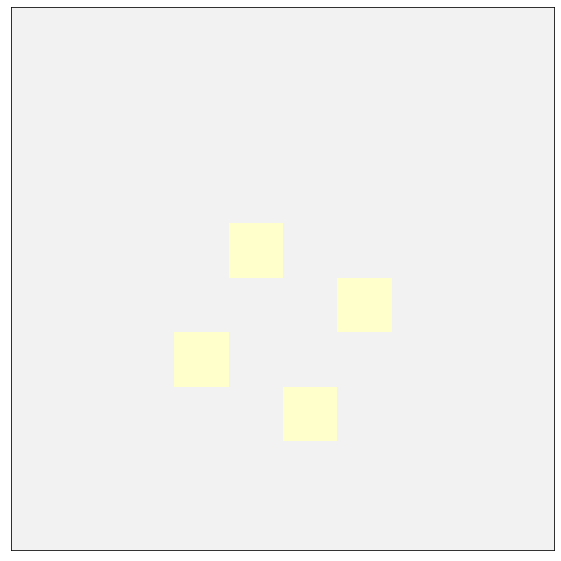

In [241]:

cmap = plt.cm.Pastel1
fig, axs = plt.subplots(figsize=(10,10))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(df.iloc[0][0], cmap=cmap, vmin=-0.1)

def animate(i):
    patch.set_data(df.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames=steps)

In [159]:
anim